In [14]:
# Importing necessary libraries

import pandas as pd
import numpy as np
import os, librosa
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
import IPython.display as ipd
import seaborn as sns
from tensorflow import keras
from keras.utils import to_categorical
from keras import layers, Sequential
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from warnings import filterwarnings
import matplotlib.pyplot as plt
filterwarnings('ignore')
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
import librosa
import librosa.display
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras import layers, models, utils
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras import layers, models, utils
import warnings

# Exploring Data Analysis


In [15]:
data = pd.read_csv("C:/Users/ASUS/Desktop/EHB328E/archive/UrbanSound8K.csv")
path_for_audio = 'C:/Users/ASUS/Desktop/EHB328E/archive/'

data.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [16]:
class_name = ["air_conditioner", "car_horn", "children_playing", "dog_bark", "drilling", "engine_idling", "gun_shot", "jackhammer", "siren", "street_music"]

In [17]:
data.info()
data.describe()
data.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8732 entries, 0 to 8731
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   slice_file_name  8732 non-null   object 
 1   fsID             8732 non-null   int64  
 2   start            8732 non-null   float64
 3   end              8732 non-null   float64
 4   salience         8732 non-null   int64  
 5   fold             8732 non-null   int64  
 6   classID          8732 non-null   int64  
 7   class            8732 non-null   object 
dtypes: float64(2), int64(4), object(2)
memory usage: 545.9+ KB


slice_file_name    0
fsID               0
start              0
end                0
salience           0
fold               0
classID            0
class              0
dtype: int64

## DISTRUBUTION OF CLASSES

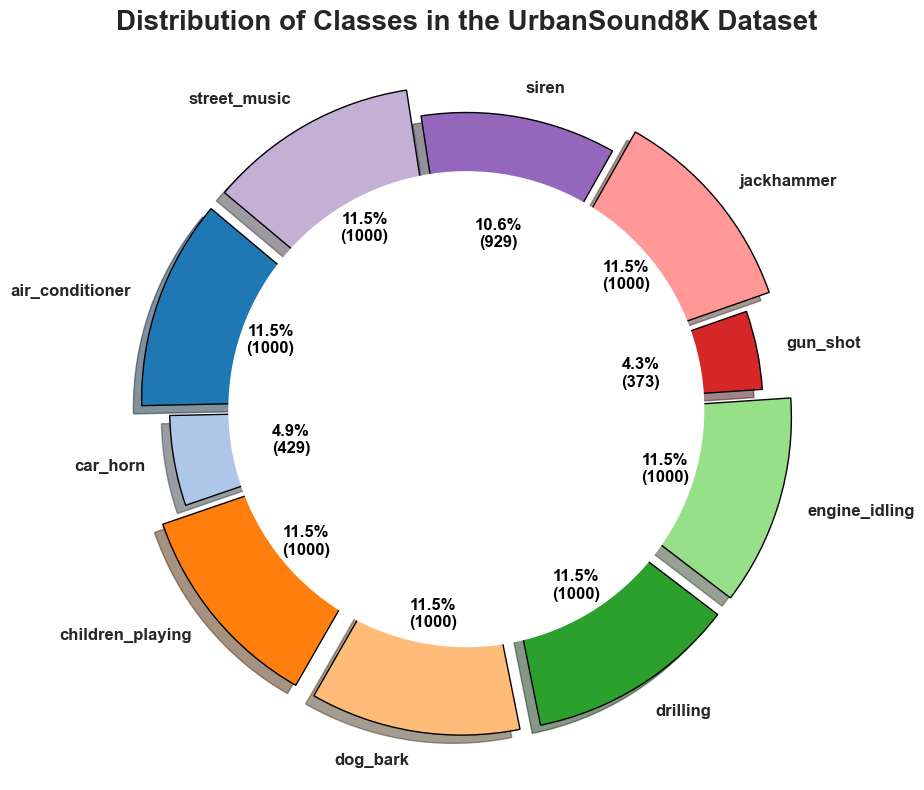

In [18]:
class_distribution = data['class'].value_counts().sort_index()

def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%\n({:d})".format(pct, absolute)

plt.figure(figsize=(12, 8))
sns.set_style("whitegrid")

explode = [0.1 if i == class_distribution.max() else 0 for i in class_distribution]

colors = plt.cm.tab20.colors  
wedges, texts, autotexts = plt.pie(class_distribution, labels=class_distribution.index, autopct=lambda pct: func(pct, class_distribution),
                                   startangle=140, colors=colors, explode=explode, shadow=True, wedgeprops={'linewidth': 1, 'edgecolor': 'black'})

plt.setp(autotexts, size=12, weight='bold', color='black')
plt.setp(texts, size=12, weight='bold')
plt.title('Distribution of Classes in the UrbanSound8K Dataset', fontsize=20, weight='bold')


centre_circle = plt.Circle((0, 0), 0.80, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.tight_layout()
plt.show()


Class : siren



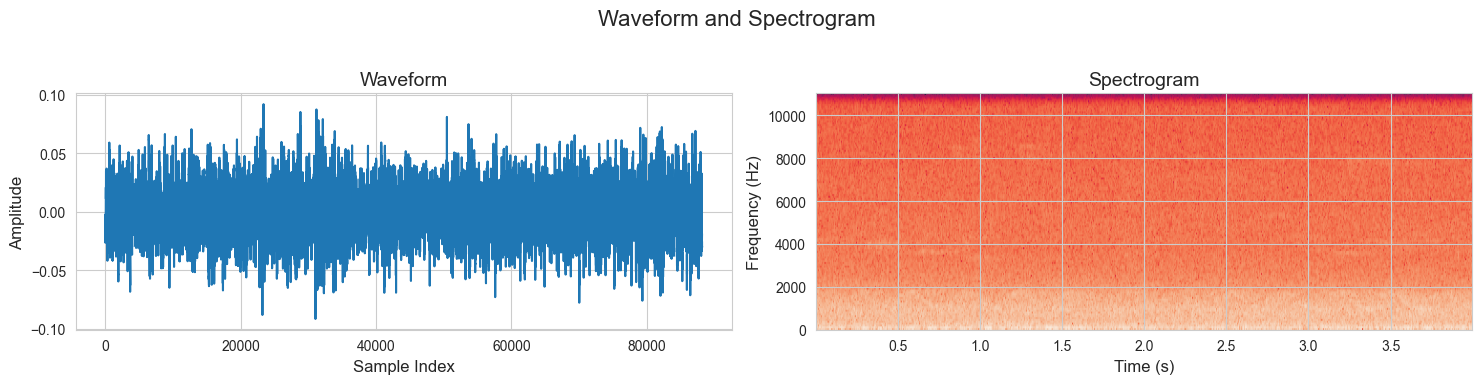

In [19]:
row = data.sample(1).iloc[0]

# Constructing file path
audioFile = os.path.join(path_for_audio, 'fold' + str(row['fold']), row['slice_file_name'])

# Loading audio file
waveform, sampleRate = librosa.load(audioFile)

# Displaying audio
print(f"Class : {row['class']}\n")
ipd.display(ipd.Audio(waveform, rate = sampleRate))

# Plot configuration
fig, axs = plt.subplots(1, 2, figsize=(15, 4))
fig.suptitle('Waveform and Spectrogram', fontsize=16)

# Displaying waveform
axs[0].plot(waveform)
axs[0].set_title('Waveform', fontsize=14)
axs[0].set_xlabel('Sample Index', fontsize=12)
axs[0].set_ylabel('Amplitude', fontsize=12)

# Displaying spectrogram
axs[1].specgram(waveform, Fs=sampleRate)
axs[1].set_title('Spectrogram', fontsize=14)
axs[1].set_xlabel('Time (s)', fontsize=12)
axs[1].set_ylabel('Frequency (Hz)', fontsize=12)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


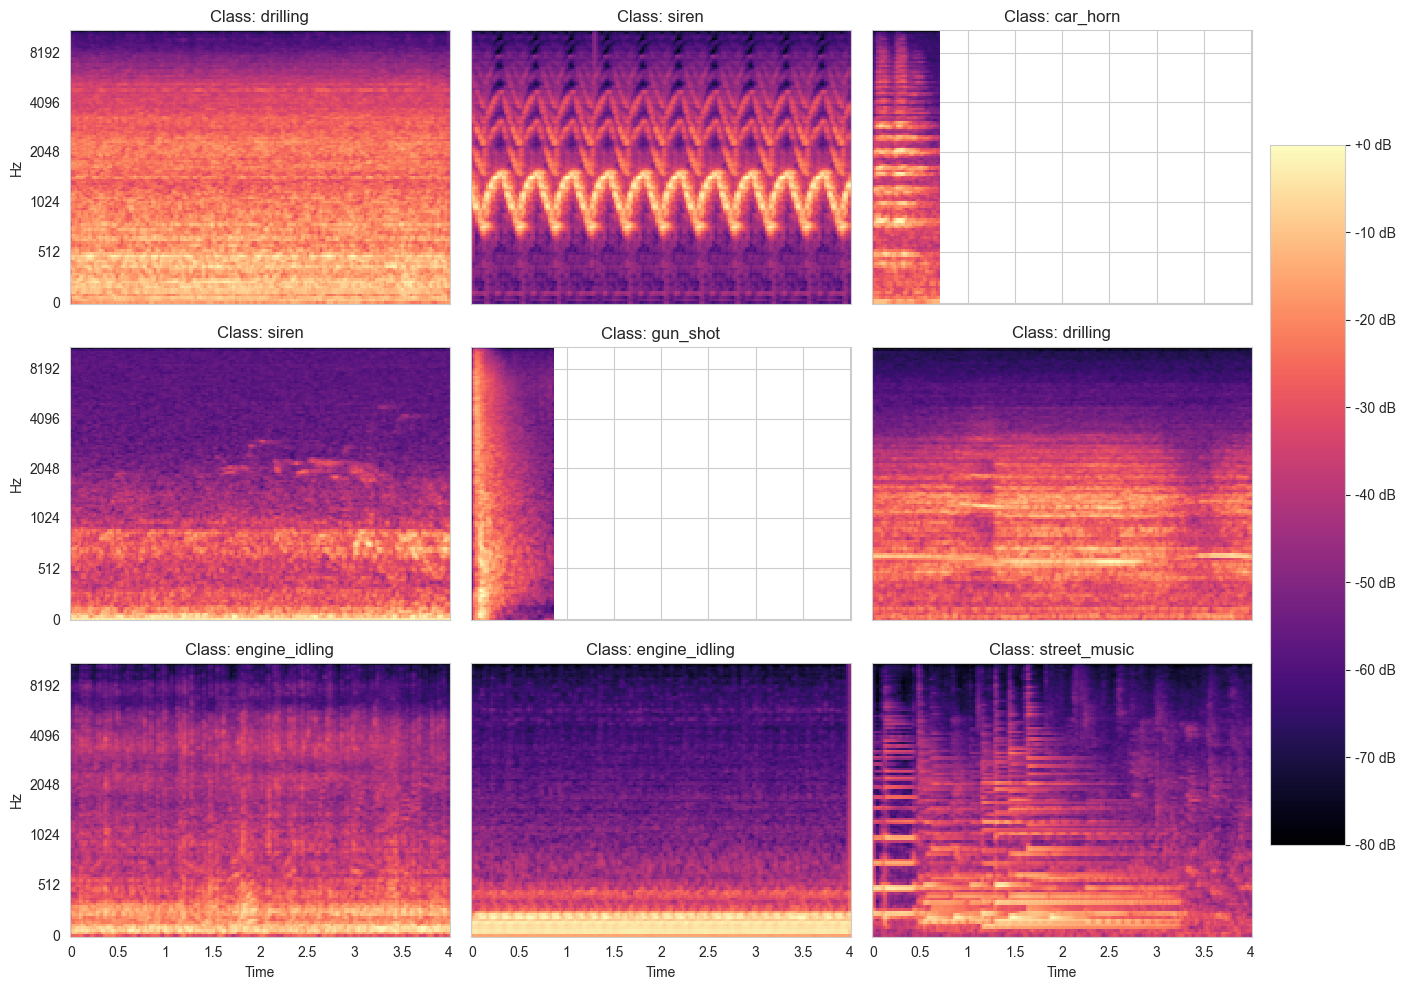

In [20]:
data = pd.read_csv("C:/Users/ASUS/Desktop/EHB328E/archive/UrbanSound8K.csv")
sample_files = data.sample(9)   #Randomly select 9 files for display
audio_path = 'C:/Users/ASUS/Desktop/EHB328E/archive/'

fig, axes = plt.subplots(3, 3, figsize=(15, 10), sharex='col', sharey='row')
for i, (idx, row) in enumerate(sample_files.iterrows()):
    file_path = os.path.join(audio_path, 'fold'+str(row['fold']), row['slice_file_name'])
    y, sr = librosa.load(file_path)
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)

    log_S = librosa.power_to_db(S, ref=np.max)

    ax = axes[i // 3, i % 3]
    img = librosa.display.specshow(log_S, sr=sr, x_axis='time', y_axis='mel', ax=ax)
    ax.set_title('Class: ' + str(row['class']))
    ax.label_outer()

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(img, cax=cbar_ax, format='%+2.0f dB')

plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()



# Preprocessing Data

## Data Augmentation


In [21]:
def augmentData(waveform):
    waveform = librosa.effects.preemphasis(waveform)
    
    if np.random.rand() < 0.5:
        rate = np.random.uniform(0.8, 1.2)
        waveform = librosa.effects.time_stretch(waveform, rate = rate)

    waveform += 0.01 * np.random.normal(size = waveform.shape)

    return waveform

In [22]:
def mfccExtract(file):
    waveform, sampleRate = librosa.load(file)
    
    features = librosa.feature.mfcc(y = waveform, sr = sampleRate, n_mfcc = 64)
    return np.mean(features, axis = 1)

In [23]:
extractAll = []

for index, row in tqdm(data.iterrows()):
    audioFile = os.path.join(path_for_audio, 'fold' + str(row['fold']), row['slice_file_name'])
    
    # Extracting features and appending them
    features = mfccExtract(audioFile)
    extractAll.append([features, row['class']])

8732it [02:06, 69.27it/s] 


In [24]:
featuresDf = pd.DataFrame(extractAll, columns = ['Features', 'Class'])
featuresDf.head()

,Features,Class
0,"[-211.93698, 62.581207, -122.81315, -60.745293...",dog_bark
1,"[-417.0052, 99.336624, -42.995586, 51.073326, ...",children_playing
2,"[-452.39316, 112.36253, -37.578068, 43.195866,...",children_playing
3,"[-406.47922, 91.1966, -25.043558, 42.78452, 11...",children_playing
4,"[-439.63873, 103.86223, -42.658787, 50.690277,...",children_playing


In [25]:
x = np.array(featuresDf['Features'].tolist())
encoder = LabelEncoder()
y = encoder.fit_transform(featuresDf['Class'])
y = to_categorical(y, num_classes = 10)

In [26]:
trainX, testX, trainY, testY = train_test_split(x, y, stratify = y, random_state = 0)

# DNN

In [27]:
model = Sequential([
    layers.Dense(1024, activation = 'relu', input_shape = (64,)),
    layers.BatchNormalization(),
    
    layers.Dense(512, activation = 'relu'),
    layers.BatchNormalization(),
    
    layers.Dense(256, activation = 'relu'),
    layers.BatchNormalization(),
    
    layers.Dense(128, activation = 'relu'),
    layers.BatchNormalization(),
    
    layers.Dense(64, activation = 'relu'),
    layers.BatchNormalization(),
    
    layers.Dense(32, activation = 'relu'),
    layers.BatchNormalization(),
    
    layers.Dense(10, activation = 'softmax')
])

# Defining optimizer, loss function, and metrics
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 1024)           │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 774,314 (2.95 MB)

 Trainable params: 770,282 (2.94 MB)

 Non-trainable params: 4,032 (15.75 KB)

In [28]:
# Adding early stopping to avoid overfitting
earlyStopping = EarlyStopping(
    monitor = 'val_accuracy',
    min_delta = 5e-4,
    patience = 5,
    restore_best_weights = True
)

In [29]:
reduceLR = ReduceLROnPlateau(
    monitor = 'val_accuracy',
    factor = 0.5,
    patience = 3,
    min_lr = 1e-5
)

In [30]:
history = model.fit(
    trainX, trainY,
    validation_data = (testX, testY),
    epochs = 50,
    callbacks = [earlyStopping, reduceLR]
)

Epoch 1/50
205/205 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.4163 - loss: 1.7548 - val_accuracy: 0.6404 - val_loss: 1.1597 - learning_rate: 0.0010
Epoch 2/50
205/205 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6637 - loss: 1.0572 - val_accuracy: 0.7151 - val_loss: 0.8859 - learning_rate: 0.0010
Epoch 3/50
205/205 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7399 - loss: 0.8149 - val_accuracy: 0.7494 - val_loss: 0.7656 - learning_rate: 0.0010
Epoch 4/50
205/205 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7885 - loss: 0.6495 - val_accuracy: 0.7939 - val_loss: 0.6592 - learning_rate: 0.0010
Epoch 5/50
205/205 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8095 - loss: 0.5892 - val_accuracy: 0.8016 - val_loss: 0.6198 - learning_rate: 0.0010
Epoch 6/50
205/205 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8414 - loss: 0.4957 - val_accuracy: 0.8301 - val_loss: 0.5477 - learning_rate: 0.0010
Epoch 7/50
205/205 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8592 - loss: 0.4467 - 

In [31]:
historyDf = pd.DataFrame(history.history)

<Figure size 1000x600 with 0 Axes>

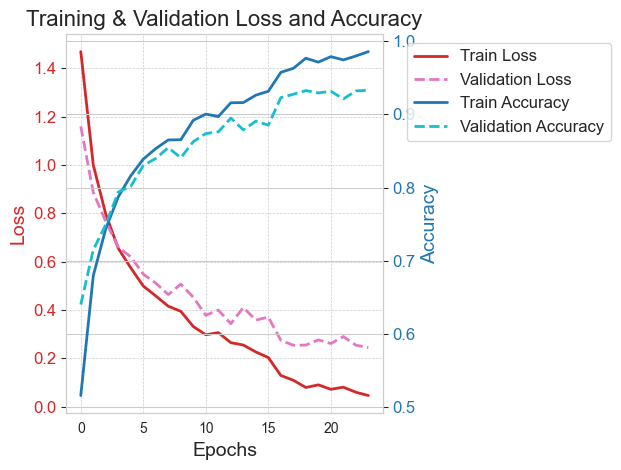

In [32]:


plt.figure(figsize=(10, 6), dpi=100)

fig, ax1 = plt.subplots()

ax1.set_xlabel('Epochs', fontsize=14)  # Larger font size for axis labels
ax1.set_ylabel('Loss', color='tab:red', fontsize=14)
ax1.plot(historyDf['loss'], label='Train Loss', color='tab:red', linestyle='-', marker='', linewidth=2, markersize=8)
ax1.plot(historyDf['val_loss'], label='Validation Loss', color='tab:pink', linestyle='--', marker='', linewidth=2, markersize=8)
ax1.tick_params(axis='y', labelcolor='tab:red', labelsize=12)  

ax1.grid(True, which='both', linestyle='--', linewidth=0.5)
ax2 = ax1.twinx()  
ax2.set_ylabel('Accuracy', color='tab:blue', fontsize=14)
ax2.plot(historyDf['accuracy'], label='Train Accuracy', color='tab:blue', linestyle='-', marker='', linewidth=2, markersize=8)
ax2.plot(historyDf['val_accuracy'], label='Validation Accuracy', color='tab:cyan', linestyle='--', marker='', linewidth=2, markersize=8)
ax2.tick_params(axis='y', labelcolor='tab:blue', labelsize=12)

handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(handles1 + handles2, labels1 + labels2, loc='upper left', bbox_to_anchor=(1.05, 1), fontsize=12)

plt.title('Training & Validation Loss and Accuracy', fontsize=16)
plt.tight_layout()
plt.show()


In [33]:
score = model.evaluate(testX, testY)
print(f'Validation Loss: {score[0]:.4f}')
print(f'Validation Accuracy: {score[1] * 100:.2f}%')

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9312 - loss: 0.2626
Validation Loss: 0.2545
Validation Accuracy: 93.22%


69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


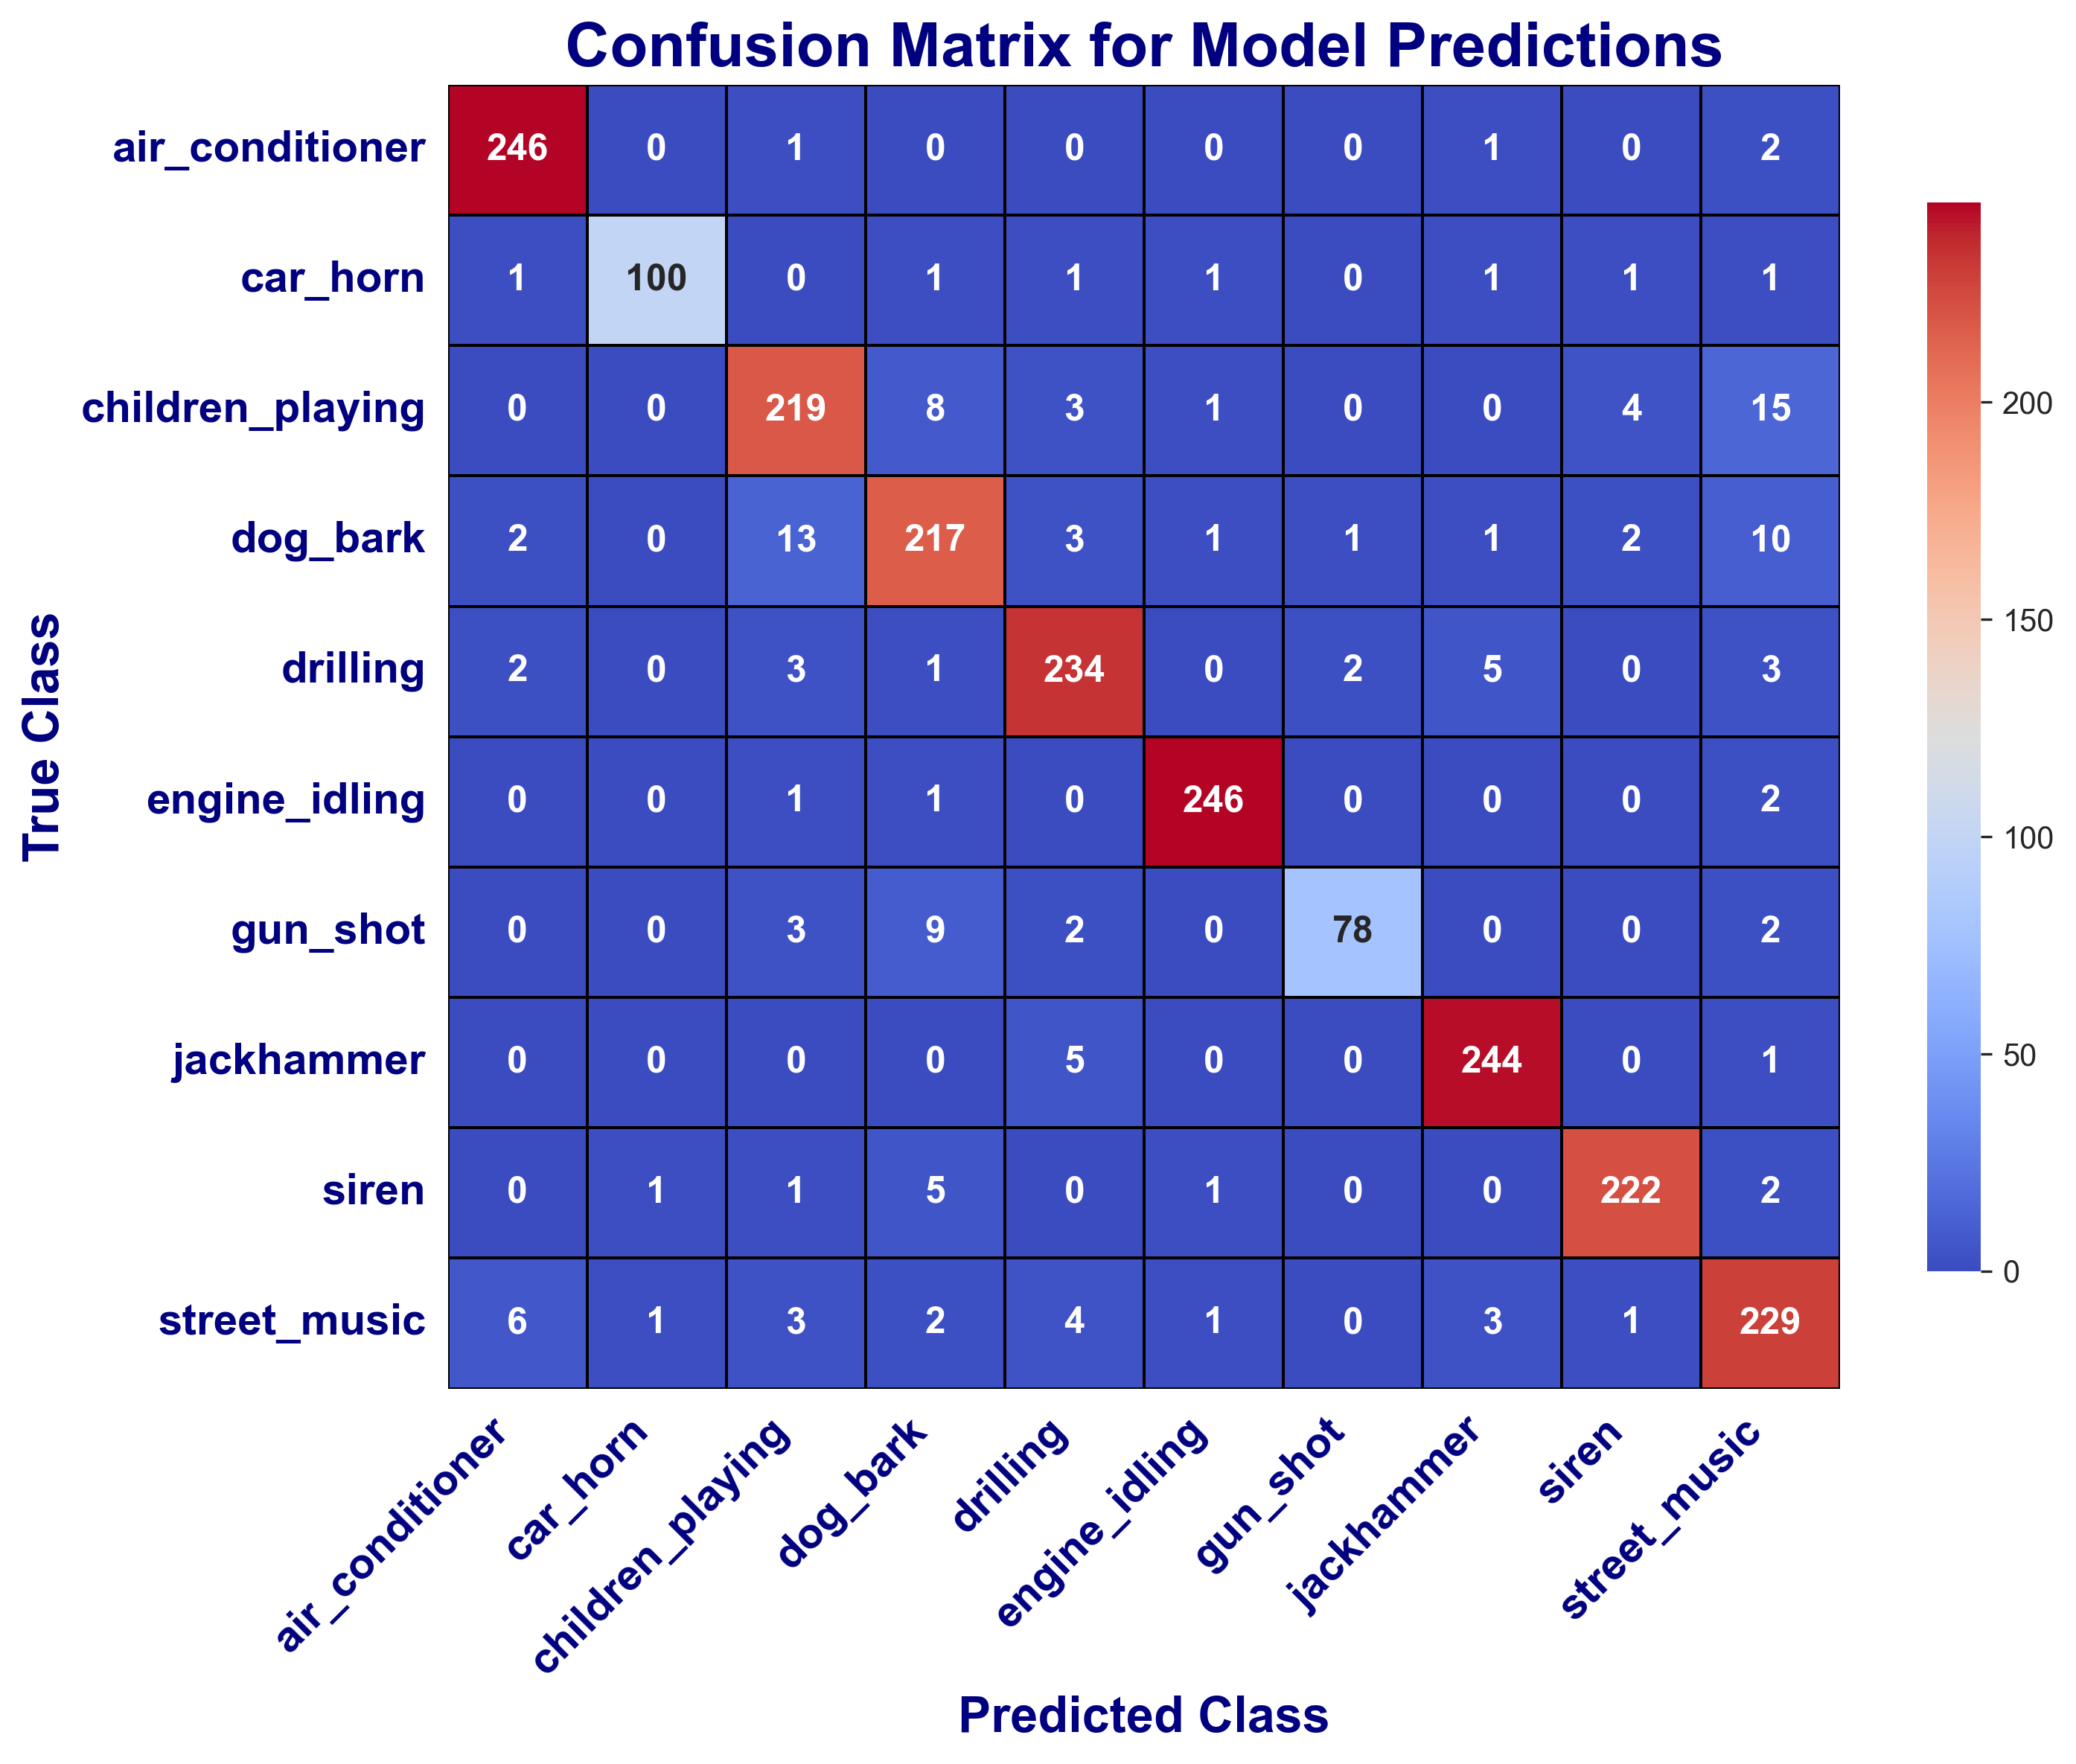

In [34]:
pred = np.argmax(model.predict(testX), axis=1)
true = np.argmax(testY, axis=1)

matrix = confusion_matrix(true, pred)

plt.figure(figsize=(10, 8), dpi=300) 

sns.heatmap(matrix, annot=True, fmt='d', cmap='coolwarm',  
            cbar=True, cbar_kws={"shrink": .82},  
            xticklabels=encoder.classes_, yticklabels=encoder.classes_,
            annot_kws={"size": 12, "weight": "bold"},  
            linewidths=.5, linecolor='black')  

plt.title('Confusion Matrix for Model Predictions', fontsize=20, fontweight='bold', color='navy')
plt.xlabel('Predicted Class', fontsize=16, fontweight='bold', color='navy')
plt.ylabel('True Class', fontsize=16, fontweight='bold', color='navy')

plt.xticks(rotation=45, ha="right", fontsize=14, fontweight='bold', color='navy')
plt.yticks(rotation=0, va="center", fontsize=14, fontweight='bold', color='navy')

plt.tight_layout()
plt.show()


In [35]:



y_pred = model.predict(testX)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(testY, axis=1)

report = classification_report(y_true, y_pred_classes, target_names=['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5', 'Class 6', 'Class 7', 'Class 8', 'Class 9'])

print(report)


69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
              precision    recall  f1-score   support

     Class 0       0.96      0.98      0.97       250
     Class 1       0.98      0.93      0.96       107
     Class 2       0.90      0.88      0.89       250
     Class 3       0.89      0.87      0.88       250
     Class 4       0.93      0.94      0.93       250
     Class 5       0.98      0.98      0.98       250
     Class 6       0.96      0.83      0.89        94
     Class 7       0.96      0.98      0.97       250
     Class 8       0.97      0.96      0.96       232
     Class 9       0.86      0.92      0.89       250

    accuracy                           0.93      2183
   macro avg       0.94      0.93      0.93      2183
weighted avg       0.93      0.93      0.93      2183



# Feature extracting

In [36]:
import IPython.display as ipd

In [37]:
df = pd.read_csv("C:/Users/ASUS/Desktop/EHB328E/archive/UrbanSound8k.csv")
df.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


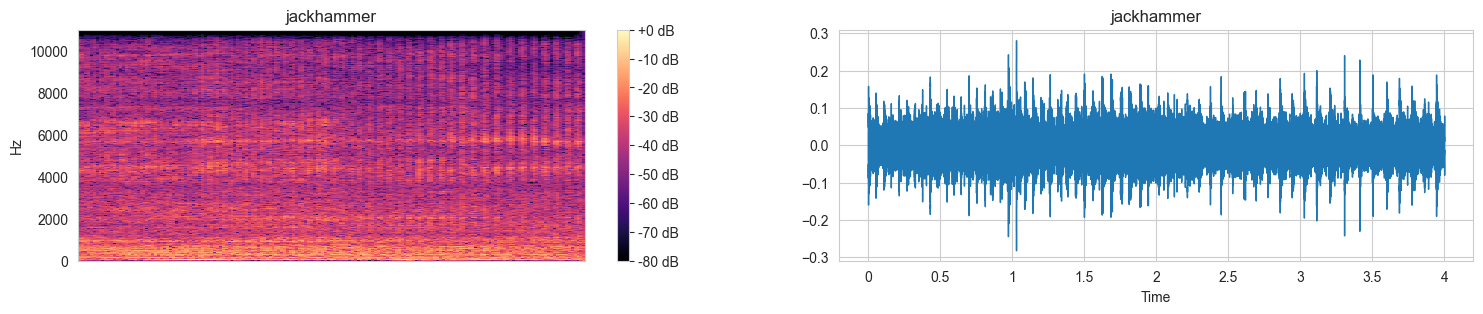

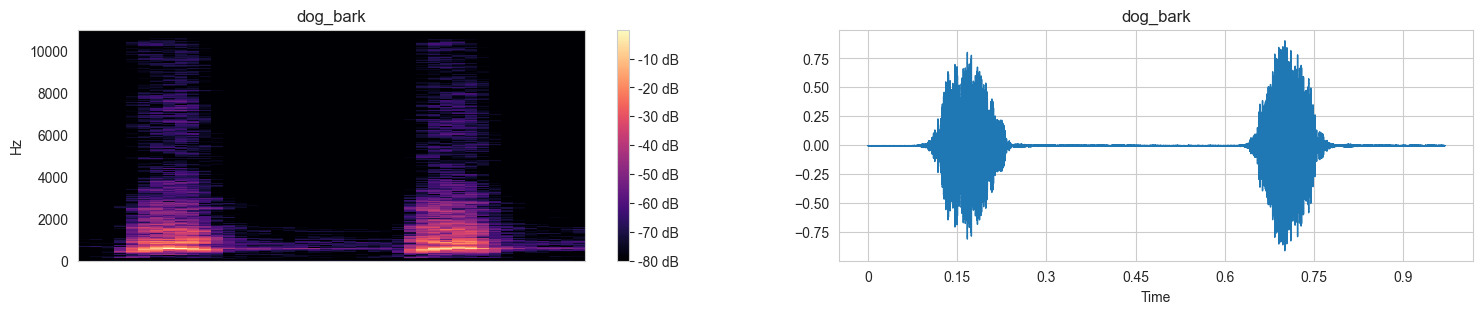

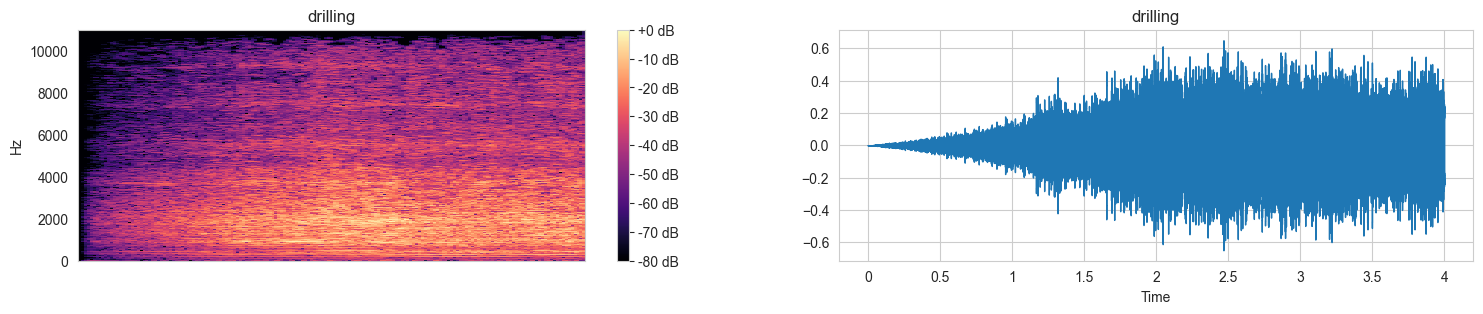

In [38]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt

for i in range(192, 197, 2):
    audio_file_path = 'C:/Users/ASUS/Desktop/EHB328E/archive/fold' + str(df["fold"][i]) + '/' + df["slice_file_name"][i]
    
    data, sr = librosa.load(audio_file_path)
    D = librosa.amplitude_to_db(np.abs(librosa.stft(data)), ref=np.max)
    
    plt.figure(figsize=(18, 3))
    
    plt.subplot(1, 2, 1)
    librosa.display.specshow(D, y_axis='linear')
    plt.colorbar(format='%+2.0f dB')
    plt.title(df["class"][i])
    
    plt.subplot(1, 2, 2)
    librosa.display.waveshow(data, sr=sr)
    plt.title(df["class"][i])
    
    plt.show()

In [39]:

data, sr = librosa.load('C:/Users/ASUS/Desktop/EHB328E/archive/fold5/100032-3-0-0.wav')
arr = librosa.feature.melspectrogram(y = data, sr = sr)
arr.shape

(128, 14)

In [40]:
features = []
labels = []

def parser():
    for i in range(df.shape[0]):
        file_name = 'C:/Users/ASUS/Desktop/EHB328E/archive/fold' + str(df["fold"][i]) + '/' + df["slice_file_name"][i]
        data, sr = librosa.load(file_name, res_type='kaiser_fast') 
        mels = np.mean(librosa.feature.melspectrogram(y = data, sr = sr), axis=1)        
        features.append(mels)
        labels.append(df["classID"][i])

    return features, labels

In [41]:
x, y = parser()

In [42]:
'''Final Data'''
X = np.array(x)
Y = np.array(y)

print(X.shape)
print(Y.shape)

(8732, 128)
(8732,)


In [43]:
print(X.dtype)
print(Y.dtype)

float32
int64


In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state = 1)

In [45]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((6549, 128), (6549,), (2183, 128), (2183,))

# RANDOM FOREST

Random Forest Accuracy: 0.8649112764739554
Random Forest Log Loss: 0.655317736429301
              precision    recall  f1-score   support

           0       0.85      0.95      0.90       203
           1       0.95      0.71      0.81        86
           2       0.71      0.79      0.75       183
           3       0.90      0.85      0.87       201
           4       0.87      0.86      0.87       206
           5       0.95      0.97      0.96       193
           6       0.86      0.75      0.80        72
           7       0.88      0.92      0.90       208
           8       0.92      0.92      0.92       165
           9       0.82      0.78      0.80       230

    accuracy                           0.86      1747
   macro avg       0.87      0.85      0.86      1747
weighted avg       0.87      0.86      0.86      1747



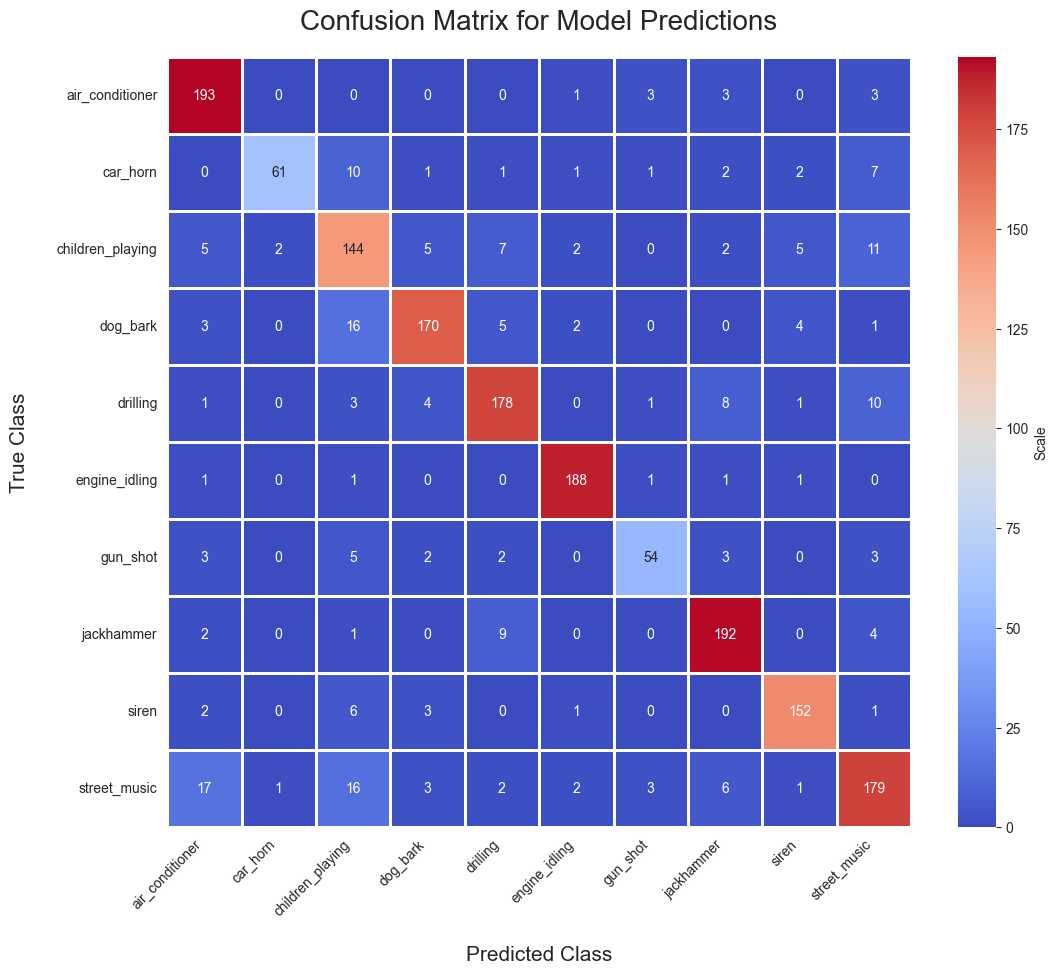

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, log_loss
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

forest = RandomForestClassifier()
forest.fit(X_train, y_train)

y_pred_proba = forest.predict_proba(X_test)
y_pred = forest.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
loss = log_loss(y_test, y_pred_proba)
print(f'Random Forest Accuracy: {accuracy}')
print(f'Random Forest Log Loss: {loss}')

print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12, 10))
ax = sns.heatmap(cm, annot=True, fmt="d", linewidths=2, cmap="coolwarm", xticklabels=class_name, yticklabels=class_name, cbar_kws={'label': 'Scale'})
ax.set_title('Confusion Matrix for Model Predictions', fontsize=20, pad=20)
ax.set_xlabel('Predicted Class', fontsize=15, labelpad=20)
ax.set_ylabel('True Class', fontsize=15, labelpad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.show()


# LSTM

In [47]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical

In [48]:

X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [49]:
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.5))
model.add(LSTM(64))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(y_train.shape[1], activation='sigmoid'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), verbose=2, shuffle=False)

Epoch 1/100
219/219 - 3s - 12ms/step - accuracy: 0.2472 - loss: 2.1200 - val_accuracy: 0.3572 - val_loss: 1.8209
Epoch 2/100
219/219 - 0s - 2ms/step - accuracy: 0.3616 - loss: 1.8170 - val_accuracy: 0.4499 - val_loss: 1.5798
Epoch 3/100
219/219 - 0s - 1ms/step - accuracy: 0.4094 - loss: 1.6790 - val_accuracy: 0.4797 - val_loss: 1.4545
Epoch 4/100
219/219 - 0s - 2ms/step - accuracy: 0.4528 - loss: 1.5776 - val_accuracy: 0.5386 - val_loss: 1.3561
Epoch 5/100
219/219 - 0s - 1ms/step - accuracy: 0.4870 - loss: 1.5057 - val_accuracy: 0.5335 - val_loss: 1.3178
Epoch 6/100
219/219 - 0s - 1ms/step - accuracy: 0.5150 - loss: 1.4473 - val_accuracy: 0.5736 - val_loss: 1.2379
Epoch 7/100
219/219 - 0s - 1ms/step - accuracy: 0.5306 - loss: 1.3975 - val_accuracy: 0.5861 - val_loss: 1.2054
Epoch 8/100
219/219 - 0s - 1ms/step - accuracy: 0.5452 - loss: 1.3556 - val_accuracy: 0.5982 - val_loss: 1.1711
Epoch 9/100
219/219 - 0s - 1ms/step - accuracy: 0.5573 - loss: 1.3306 - val_accuracy: 0.6211 - val_loss

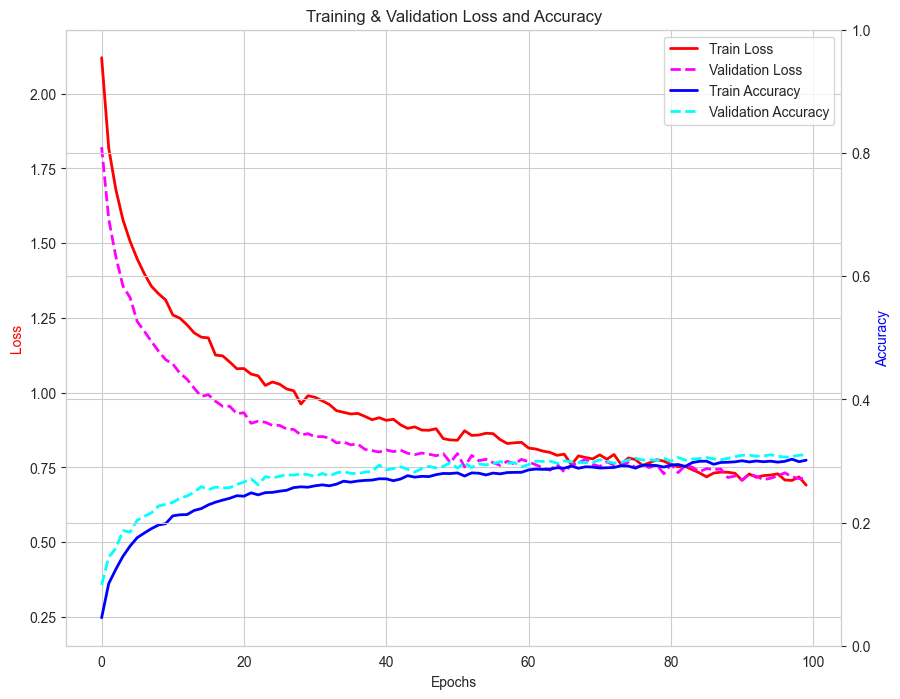

In [50]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))

plt.plot(history.history['loss'], color='red', linewidth=2, label='Train Loss')
plt.plot(history.history['val_loss'], color='magenta', linestyle='--', linewidth=2, label='Validation Loss')

plt.plot(history.history['accuracy'], color='blue', linewidth=2, label='Train Accuracy')
plt.plot(history.history['val_accuracy'], color='cyan', linestyle='--', linewidth=2, label='Validation Accuracy')

plt.title('Training & Validation Loss and Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss', color='red')
plt.legend(loc='upper right')

ax2 = plt.gca().twinx()
ax2.set_ylabel('Accuracy', color='blue')

plt.grid(True)
plt.show()


55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


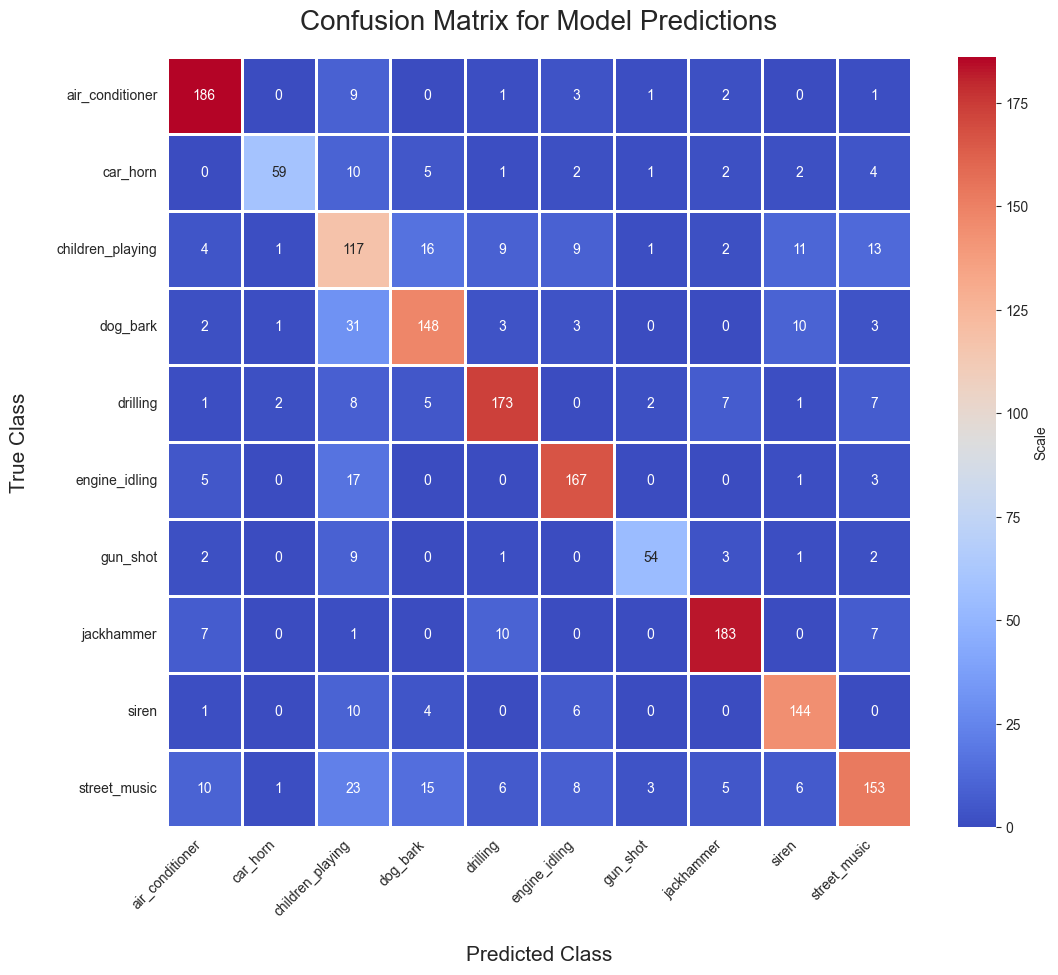

In [51]:

from sklearn.metrics import confusion_matrix
import seaborn as sns


y_pred_proba = model.predict(X_test)
y_pred = np.argmax(y_pred_proba, axis=1)

cm = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
plt.figure(figsize=(12, 10))
ax = sns.heatmap(cm, annot=True, fmt="d", linewidths=2, cmap="coolwarm", xticklabels=class_name, yticklabels=class_name, cbar_kws={'label': 'Scale'})
ax.set_title('Confusion Matrix for Model Predictions', fontsize=20, pad=20)
ax.set_xlabel('Predicted Class', fontsize=15, labelpad=20)
ax.set_ylabel('True Class', fontsize=15, labelpad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.show()

    

# cnn

In [52]:

import warnings
warnings.simplefilter("ignore")

data = pd.read_csv("C:/Users/ASUS/Desktop/EHB328E/archive/UrbanSound8K.csv")
path_for_audio = 'C:/Users/ASUS/Desktop/EHB328E/archive/'

def extract_features(file_name):
    try:
        audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast')
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
        mfccs_scaled = np.mean(mfccs.T, axis=0)
    except Exception as e:
        print(f"Error encountered while parsing file: {file_name}")
        return None 
    return mfccs_scaled

features = []
for index, row in data.iterrows():
    file_name = os.path.join(path_for_audio, 'fold'+str(row["fold"]), str(row["slice_file_name"]))
    class_label = row["class"]
    data = extract_features(file_name)
    features.append([data, class_label])

featuresdf = pd.DataFrame(features, columns=['feature','class_label'])

X = np.array(featuresdf['feature'].tolist())
y = np.array(featuresdf['class_label'].tolist())

le = LabelEncoder()
yy = utils.to_categorical(le.fit_transform(y))

x_train, x_test, y_train, y_test = train_test_split(X, yy, test_size=0.2, random_state=42)

x_train = x_train.reshape(x_train.shape[0], 40, 1)
x_test = x_test.reshape(x_test.shape[0], 40, 1)

model = models.Sequential()
model.add(layers.Conv1D(64, kernel_size=2, activation='relu', input_shape=(40, 1)))
model.add(layers.MaxPooling1D(pool_size=2))
model.add(layers.Dropout(0.3))
model.add(layers.Conv1D(128, kernel_size=2, activation='relu'))
model.add(layers.MaxPooling1D(pool_size=2))
model.add(layers.Dropout(0.3))
model.add(layers.Conv1D(256, kernel_size=2, activation='relu'))
model.add(layers.MaxPooling1D(pool_size=2))
model.add(layers.Dropout(0.3))
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(10, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

history = model.fit(x_train, y_train, batch_size=32, epochs=50, validation_data=(x_test, y_test), verbose=1)

score = model.evaluate(x_test, y_test, verbose=0)
print(f"Test Accuracy: {score[1]}")

y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1) 
y_true = np.argmax(y_test, axis=1) 
print(classification_report(y_true, y_pred_classes))




Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 39, 64)         │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 19, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 19, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 18, 128)        │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 9, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 9, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 8, 256)         │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 4, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 4, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 347,466 (1.33 MB)

 Trainable params: 347,466 (1.33 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.2220 - loss: 3.0391 - val_accuracy: 0.4362 - val_loss: 1.6445
Epoch 2/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3978 - loss: 1.6889 - val_accuracy: 0.5467 - val_loss: 1.3606
Epoch 3/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4810 - loss: 1.4979 - val_accuracy: 0.5942 - val_loss: 1.2230
Epoch 4/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5114 - loss: 1.3934 - val_accuracy: 0.6239 - val_loss: 1.1384
Epoch 5/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5507 - loss: 1.2902 - val_accuracy: 0.6651 - val_loss: 1.0265
Epoch 6/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5743 - loss: 1.2198 - val_accuracy: 0.6840 - val_loss: 0.9569
Epoch 7/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6103 - loss: 1.1325 - val_accuracy: 0.7350 - val_loss: 0.8580
Epoch 8/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6458 - loss: 1.0309 - val_accuracy: 0.

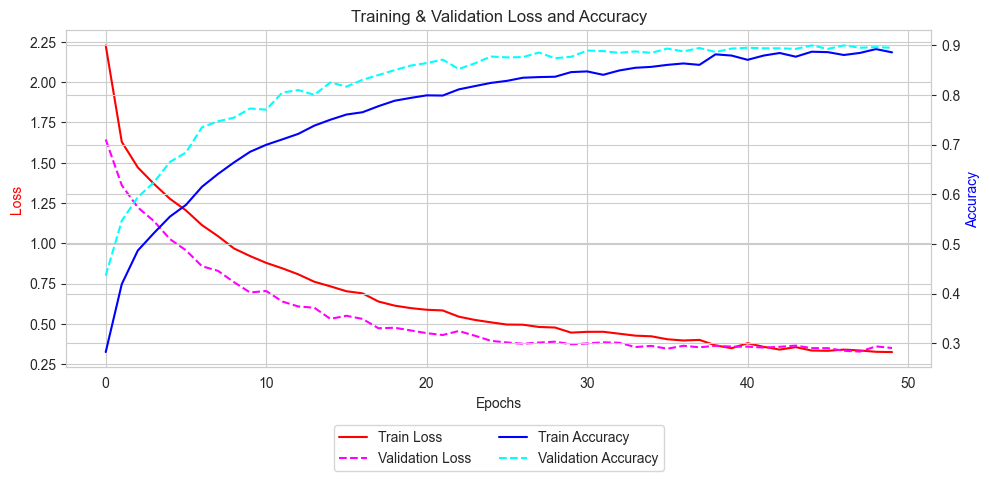

In [53]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss', color='red', linestyle='-')
plt.plot(history.history['val_loss'], label='Validation Loss', color='magenta', linestyle='--')

ax1 = plt.gca()
ax2 = ax1.twinx()
ax2.plot(history.history['accuracy'], label='Train Accuracy', color='blue', linestyle='-')
ax2.plot(history.history['val_accuracy'], label='Validation Accuracy', color='cyan', linestyle='--')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss', color='red')
ax2.set_ylabel('Accuracy', color='blue')
plt.title('Training & Validation Loss and Accuracy')

lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2)

plt.tight_layout(rect=[0, 0, 1, 0.85])

plt.show()


Confusion Matrix:


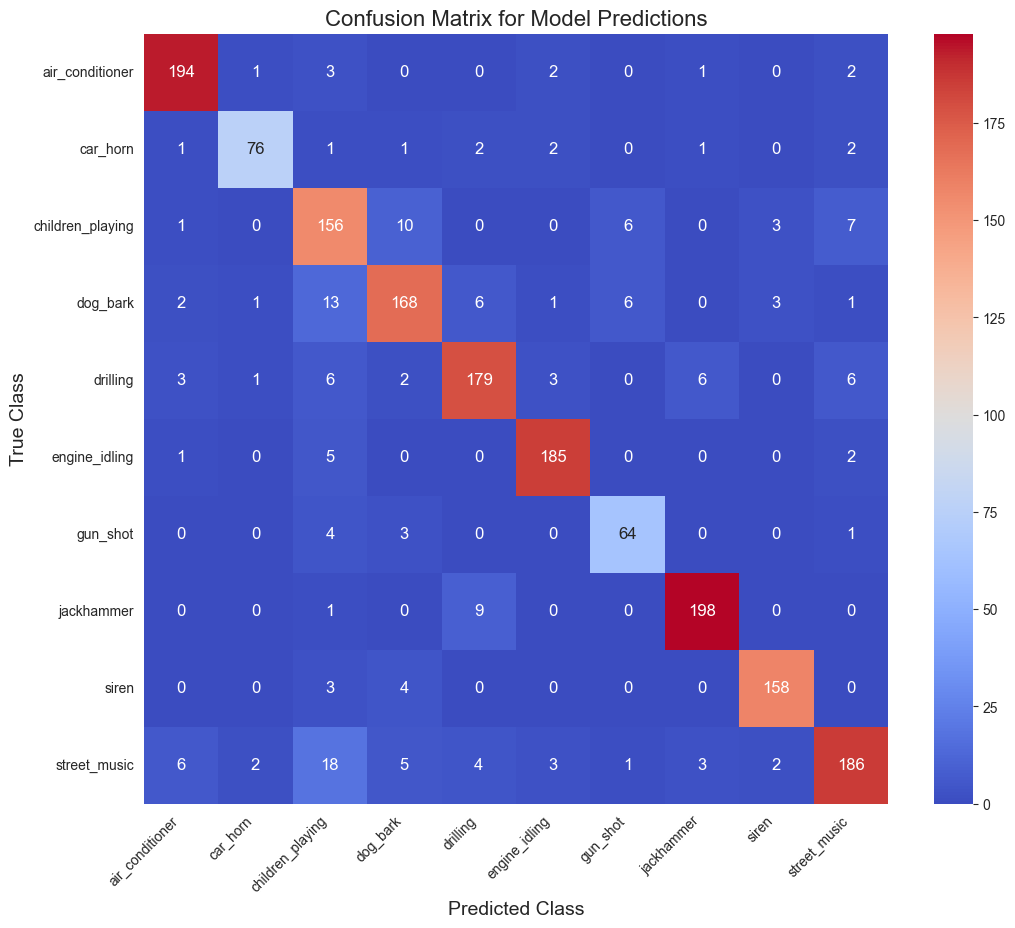

In [54]:
print('Confusion Matrix:')
cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm', cbar=True, annot_kws={"size": 12})

plt.title('Confusion Matrix for Model Predictions', fontsize=16)
plt.xlabel('Predicted Class', fontsize=14)
plt.ylabel('True Class', fontsize=14)

class_names = ['air_conditioner', 'car_horn', 'children_playing', 'dog_bark', 'drilling',
               'engine_idling', 'gun_shot', 'jackhammer', 'siren', 'street_music']
plt.xticks(np.arange(len(class_names)) + 0.5, class_names, rotation=45, ha='right')
plt.yticks(np.arange(len(class_names)) + 0.5, class_names, rotation=0)

plt.show()


## CNN CLASSIFICATION REPORT

In [55]:
print("Classification Report: \n")

y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

report = classification_report(y_true, y_pred_classes, target_names=le.classes_)
print(report)

Classification Report: 

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
                  precision    recall  f1-score   support

 air_conditioner       0.93      0.96      0.94       203
        car_horn       0.94      0.88      0.91        86
children_playing       0.74      0.85      0.79       183
        dog_bark       0.87      0.84      0.85       201
        drilling       0.90      0.87      0.88       206
   engine_idling       0.94      0.96      0.95       193
        gun_shot       0.83      0.89      0.86        72
      jackhammer       0.95      0.95      0.95       208
           siren       0.95      0.96      0.95       165
    street_music       0.90      0.81      0.85       230

        accuracy                           0.90      1747
       macro avg       0.90      0.90      0.89      1747
    weighted avg       0.90      0.90      0.90      1747

